In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

In [2]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
import pylab as pl
from scipy import stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [3]:
pl.style.use('fabiostyle')

# needs to find the library of functions
sys.path.append('../../../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [4]:
# %%javascript
# var nb = IPython.notebook;
# var kernel = IPython.notebook.kernel;
# var command = "NOTEBOOK_NAME = '" + nb.base_url + nb.notebook_path + "'";
# kernel.execute(command);

In [5]:
# NOTEBOOK_NAME = NOTEBOOK_NAME.split('/')[-1][:-6]
NOTEBOOK_NAME = 'decoding_through_session'

In [6]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [7]:
folder = './autorestore/preprocessing'
for var in ('time_ax', 'traces', 'events', 'areas', 'cycles',
            'is_rewardt', 'is_CSmt', 'CYCLE_START', 'CS_DURATION', 'DELAY'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))
    
folder = './autorestore/lambo'
for var in ('lick_dis', 'n_licks', 'lick_scores', 'lick_scores_cv'): 
    exec('%s = ut.load_variable(\'%s\', folder=\'%s\')'%(var, var, folder))

In [8]:
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [9]:
n_loops = 10

In [10]:
# %%time
# %%px

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC, LinearSVC
import numpy as np

# decoder = SVC(kernel='linear')
decoder = LinearSVC()
# decoder = MultinomialNB()

In [11]:
patterns = ut.extract_patterns(time_ax, traces, cycles, CYCLE_START, 0, CS_DURATION+DELAY)
patterns_evs = ut.extract_patterns(time_ax, events, cycles, CYCLE_START, 0, CS_DURATION+DELAY)
labels = (np.r_[is_rewardt] * 0) + (np.r_[is_CSmt] * 1)

In [12]:
%%time
scores = []
n_train = 10
n_test = 4
for i in range(len(labels)-n_train-n_test):
    which_train = range(i, i+n_train)
    which_test = range(i+1+n_train, i+1+n_train+n_test)
    decoder.fit(patterns_evs[which_train], labels[which_train])
    scores.append(decoder.score(patterns_evs[which_test], labels[which_test]))
    
scores = np.r_[scores]

CPU times: user 84 ms, sys: 0 ns, total: 84 ms
Wall time: 84.7 ms


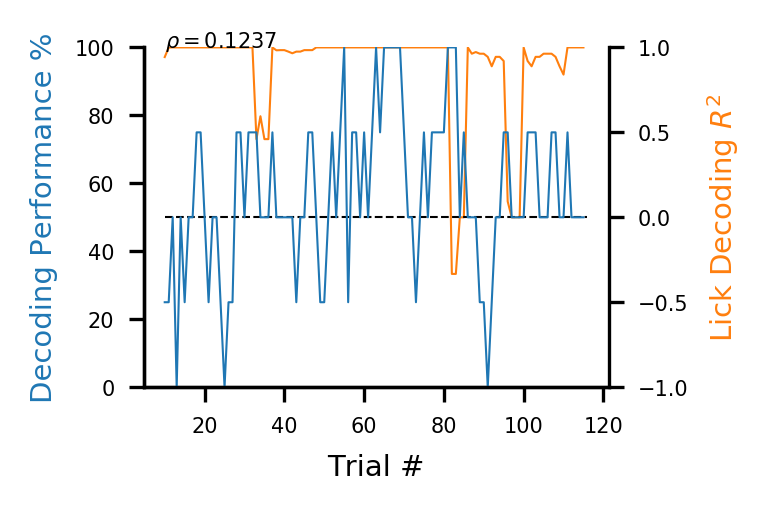

In [13]:
fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))
ax.plot(range(n_train, len(labels)-n_test), scores*100, lw=0.5)

ax.set_xlabel('Trial #')
ax.set_ylabel('Decoding Performance %', color='C0')
ax.set_ylim(0, 100)
ax.hlines(50, n_train, len(labels)-n_test, linestyles='dashed', color='k', lw=0.5, zorder=0)
ax.set_xlim(0, 120)

ax2 = ax.twinx()
ax2.spines['right'].set_visible(True)
ax2.plot(range(n_train, len(labels)-n_test), lick_scores, lw=0.5, color='C1')
ax2.set_ylabel('Lick Decoding $R^2$', color='C1')
ax2.set_ylim(-1, 1)
ax2.set_yticks(np.arange(-1, 1.1, 0.5))

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

ax.text(10, 100, r"$\rho=%.4f$"%sstats.pearsonr(lick_scores, scores)[-1], fontsize=5)

In [14]:
%%time
scores_cv = []
n_train = 10
n_test = 4
for i in range(len(labels)-n_train-n_test):
    which = range(i, i+n_train+n_test)
    scores_cv.append(ut.decode(patterns_evs[which], labels[which], decoder=decoder, cv=5))

CPU times: user 13.8 s, sys: 12 ms, total: 13.8 s
Wall time: 13.8 s


In [15]:
scores_cv_chance = np.r_[[s[1] for s in scores_cv]]
scores_cv = np.r_[[s[0] for s in scores_cv]]

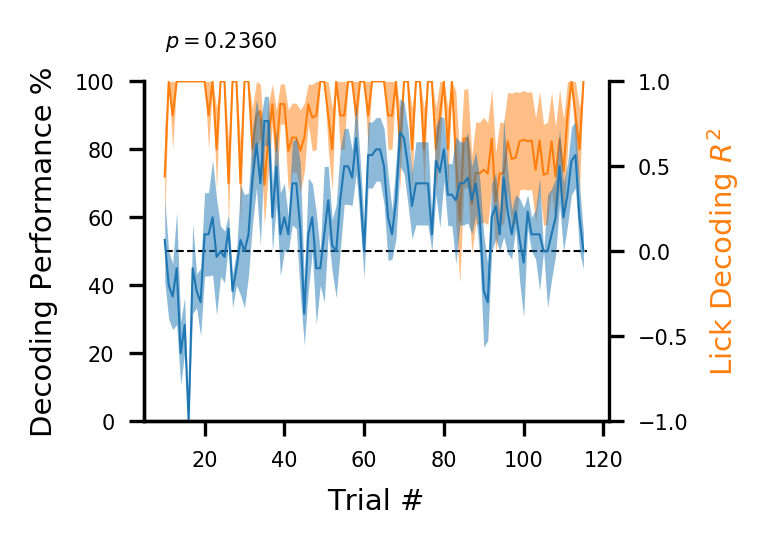

In [16]:
fig, ax = pl.subplots(1, 1, figsize=(2, 1.5))

pt.plot_shaded(range(n_train, len(labels)-n_test), scores_cv*100, ax=ax)

ax.set_xlabel('Trial #')
ax.set_ylabel('Decoding Performance %')
ax.set_ylim(0, 100)
ax.hlines(50, n_train, len(labels)-n_test, linestyles='dashed', color='k', lw=0.5, zorder=0)
ax.set_xlim(0, 120)

ax2 = ax.twinx()
ax2.spines['right'].set_visible(True)
pt.plot_shaded(range(n_train, len(labels)-n_test), lick_scores_cv, color='C1', ax=ax2,)
ax2.set_ylabel('Lick Decoding $R^2$', color='C1')
ax2.set_ylim(-1, 1)
ax2.set_yticks(np.arange(-1, 1.1, 0.5))

ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

ax.text(10, 110, "$p=%.4f$"%sstats.pearsonr(lick_scores_cv.mean(1), scores_cv.mean(1))[-1], fontsize=5)

In [17]:
from sklearn.model_selection import LeaveOneGroupOut
groups = np.repeat(range(5), (1+n_train+n_test+1)/5)
groups = groups[:i+n_train+n_test+1]
cv = LeaveOneGroupOut()

In [18]:
# %%time
weights = []
n_train = 10
n_test = 4
for i in range(len(labels)-n_train-n_test):
    which = range(i, i+1+n_train+n_test)
    w = []
    for train, test in cv.split(patterns_evs[which], labels[which], groups=groups):
        decoder.fit(patterns_evs[which][train], labels[which][train])
        w.append(abs(decoder.coef_[0])/np.sum(abs(decoder.coef_[0])))
    weights.append(np.mean(w, 0))
    
weights = np.r_[weights]

In [19]:
%%time
n_loops = 100
weights_loop = []
scores_cv_loop = []

n_train = 10
n_test = 4
for n in range(n_loops):
    labs = np.roll(labels, np.random.randint(len(labels)))[::-1]
    weights_loop_ = []
    scores_cv_loop_ = []
    # %%time
    for i in range(len(labels)-n_train-n_test):
        which = range(i, i+1+n_train+n_test)
        w = []
        s = []
        for train, test in cv.split(patterns_evs[which], labs[which], groups=groups):
            decoder.fit(patterns_evs[which][train], labs[which][train])
            w.append(abs(decoder.coef_[0])/np.sum(abs(decoder.coef_[0])))
            s.append(decoder.score(patterns_evs[which][test], labs[which][test]))
        weights_loop_.append(np.mean(w, 0))
        scores_cv_loop_.append(s)
    print '.',    
    weights = np.r_[weights]
    weights_loop.append(weights_loop_)
    scores_cv_loop.append(scores_cv_loop_)
weights_loop = np.r_[weights_loop]
scores_cv_loop = np.r_[scores_cv_loop]

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .CPU times: user 32.9 s, sys: 148 ms, total: 33.1 s
Wall time: 32.9 s



In [20]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [21]:
scores_cv.shape

(106, 5)

In [22]:
weights.shape

(106, 49)

# correlated cells:	15
Total no. of cells:	49


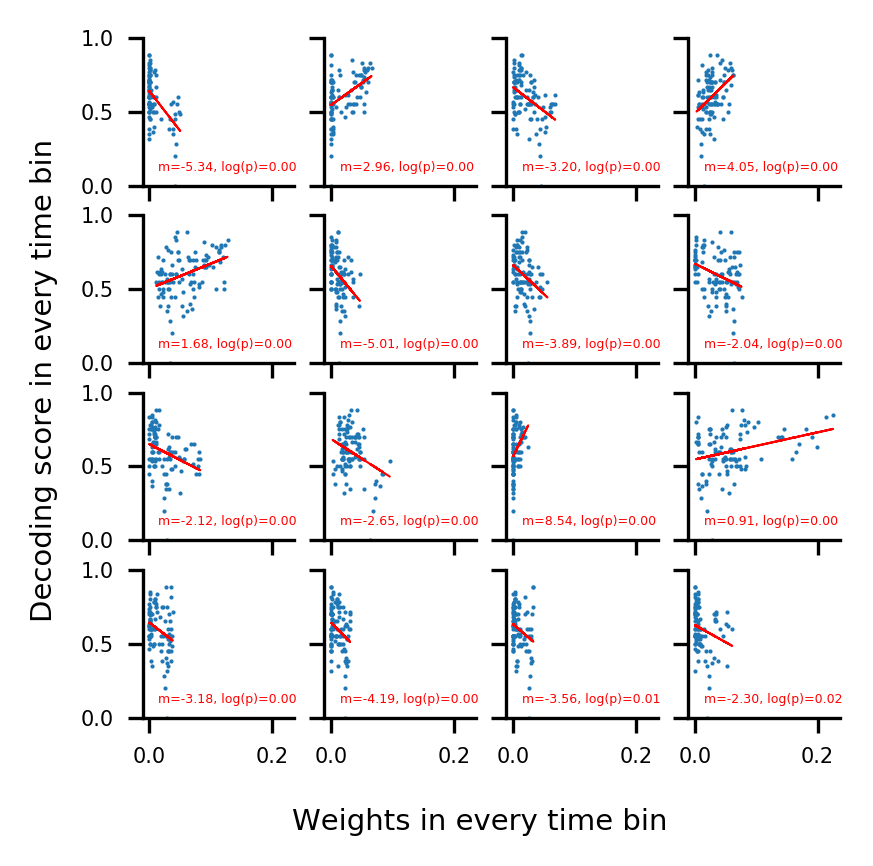

In [23]:
fig, axs = pl.subplots(4, 4, figsize=(3, 3), sharex=True, sharey=True)

p_corrs = np.r_[[sstats.pearsonr(scores_cv.mean(1), w)[-1] for w in weights.T]]

sort_them = np.argsort(p_corrs)
for ax, cell in zip(axs.flatten(), sort_them):
    ax.plot(weights[:, cell], scores_cv.mean(1), 'o', mew=0, ms=1)
    x = weights[:, cell].reshape(-1, 1)
    y = scores_cv.mean(1)
    lr.fit(x, y)
    ax.plot(x, lr.predict(x), lw=0.5, color='r')
    corr = sstats.pearsonr(weights[:, cell], scores_cv.mean(1))
#     ax.text(0.1, 0.1, r'$\rho=%.2f$, log(p)=%.2f' % corr,
#                      fontsize=3, transform=ax.transAxes, color='r')
    ax.text(0.1, 0.1, r'm=%.2f, log(p)=%.2f' % (lr.coef_[0], corr[-1]),
                     fontsize=3, transform=ax.transAxes, color='r')

axs[0][0].set_ylim(0, 1)
    
print "# correlated cells:\t", (ut.adjust_pvalues(p_corrs)<0.05).sum()
print "Total no. of cells:\t", len(p_corrs)
fig.text(0.5, 0, 'Weights in every time bin', ha='center', fontsize=7)
fig.text(0, 0.5, 'Decoding score in every time bin', va='center', fontsize=7, rotation=90)

In [24]:
p_corrs_loop = np.r_[[[sstats.pearsonr(ss.mean(1), w)[-1] for w in ww.T]
                 for ss, ww in zip(scores_cv_loop, weights_loop)]]


In [25]:
cell = 0

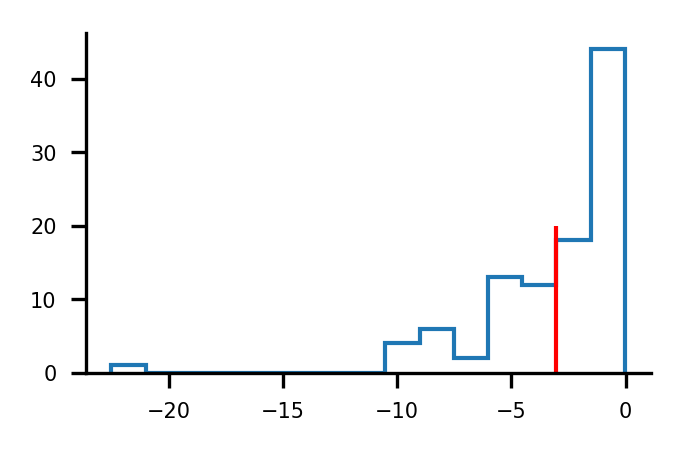

In [26]:
cell += 1
pl.hist(np.log(p_corrs_loop[:, cell]), bins=15, histtype='step',lw=1)
pl.vlines(np.mean(np.log(p_corrs_loop[:, cell])), 0, 20, lw=1, color='r')

In [27]:
# p_corrs_loop = np.concatenate([[sstats.pearsonr(np.concatenate(weights_loop[:, :, cell]), np.concatenate(scores_cv_loop).mean(1))[-1]]
#                       for cell in range(weights_loop.shape[-1])])

# correlated cells:	21.1224489796 8.17570480782
Total no. of cells:	49


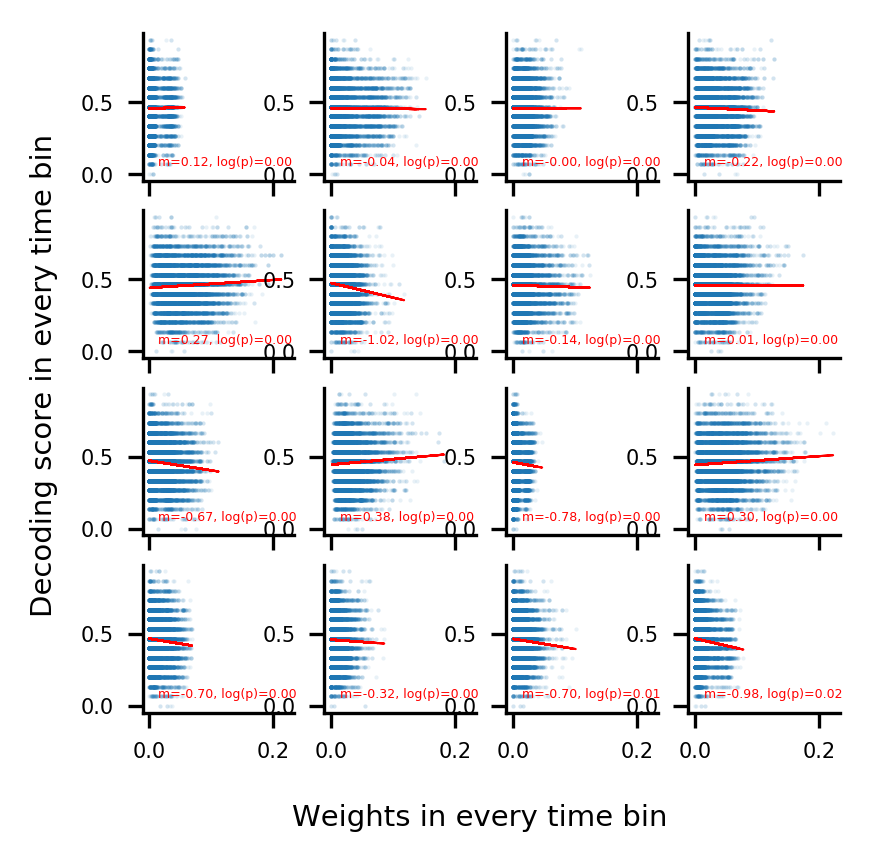

In [28]:
fig, axs = pl.subplots(4, 4, figsize=(3, 3), sharex=True, sharey=False)

# sort_them = np.argsort([np.mean(np.log(p)) for p in p_corrs_loop.T])
for cell, ax in zip(sort_them, axs.flatten()):
    x, y = np.concatenate(weights_loop[:, :, cell]), np.concatenate(scores_cv_loop).mean(1)
    ax.plot(x, y,
            'o', mew=0, ms=1, alpha=0.1)
#     ax.hist2d(x, y, bins=(np.linspace(0, 0.2, 20), np.linspace(0, 1, 20)))
    
    xx = x.reshape(-1, 1)
    lr.fit(xx, y)
    ax.plot(x, lr.predict(xx), lw=0.5, color='r')
    corr = sstats.pearsonr(weights[:, cell], scores_cv.mean(1))
#     ax.text(0.1, 0.1, r'$\rho=%.2f$, log(p)=%.2f' % corr,
#                      fontsize=3, transform=ax.transAxes, color='r')
    ax.text(0.1, 0.1, r'm=%.2f, log(p)=%.2f' % (lr.coef_[0], corr[-1]),
                     fontsize=3, transform=ax.transAxes, color='r')

corr_cells_loop = [(ut.adjust_pvalues(p)<0.05).sum() for p in p_corrs_loop.T]
print "# correlated cells:\t", np.mean(corr_cells_loop), np.std(corr_cells_loop)
print "Total no. of cells:\t", p_corrs_loop.shape[1]
fig.text(0.5, 0, 'Weights in every time bin', ha='center', fontsize=7)
fig.text(0, 0.5, 'Decoding score in every time bin', va='center', fontsize=7, rotation=90)

(0, 0.1)

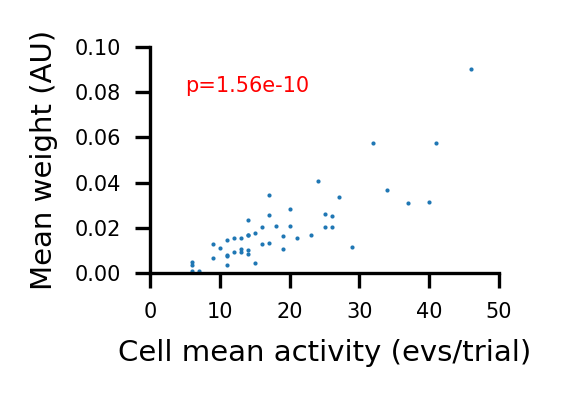

In [29]:
fig, ax = pl.subplots(1, 1, figsize=(1.5, 1))
x, y = (patterns_evs>0).sum(0), weights.mean(0)
ax.plot(x, y, 'o', ms=1, mew=0)
ax.set_xlabel('Cell mean activity (evs/trial)')
ax.set_ylabel('Mean weight (AU)')
ax.text(0.1, 0.8, 'p=%1.2e'%sstats.pearsonr(x, y)[-1], color='r', fontsize=5, transform=ax.transAxes)
ax.set_xlim(0, 50)
ax.set_ylim(0, .1)

In [30]:
save_workspace(db)

Could not store variable 'di'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'sstats'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'pickle'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'sys'. Skipping...
